In [26]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.autograd import Variable 
from typing import Tuple, Dict, List
from torch.optim import lr_scheduler
import pathlib
import os
import requests
import zipfile
from pathlib import Path
import random
from tqdm.auto import tqdm

In [28]:
import pandas as pd  # pip install pandas
from numpy import array
from os import listdir
from os.path import isfile, join
from datetime import datetime
import time
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
from numpy import array
import re
from sklearn.preprocessing import MinMaxScaler

In [29]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [43]:
data = pd.read_csv('/notebooks/CSVs/data_h1.csv')

In [44]:
data = data.drop(['time'], axis=1)

In [45]:
len(data.columns)

19

In [46]:
data_train_sc = data[:85000]
data_val_sc = data[85000:120000]
data_test_sc = data[120000:]

In [47]:
# scaler = MinMaxScaler()
# data_train = scaler.fit_transform(data_train_sc)
# data_val = scaler.transform(data_val_sc)
# data_test = scaler.transform(data_test_sc)

In [ ]:
L0 = [i for i in data_train['Label'] if i == 0]
L1 = [i for i in data_train['Label'] if i == 1]
L2 = [i for i in data_train['Label'] if i == 2]
total = len(L0) + len(L1) + len(L2)

In [24]:
cat_0 = (1/(len(L0)/total)/2)
cat_1 = (1/(len(L1)/total)/2)
cat_2 = (1/(len(L2)/total)/2)

print(f'{cat_0:.2f}', f'{cat_1:.2f}', f'{cat_2:.2f}')

0.59 6.69 6.88


In [48]:
class CustomDataset(Dataset):
    def __init__(self, df, seq_length):
        self.data = df         
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        start = index - self.seq_length
        end = index       
        indices = list(range(start, end)) 
        feature = []
        label = []
        for i in indices:             
            feature_get = self.data.iloc[i, :-1]
            # feature_get, labels = self.data.iloc[index, :-1], self.data.iloc[index, -1]  
            feature.append(torch.from_numpy(feature_get.values).float())
            # label.append(torch.from_numpy(np.asarray(labels)))
        
        
        feature = torch.stack(feature)  
        label = torch.from_numpy(np.asarray(self.data.iloc[index, -1]))
        
        return feature, label

In [52]:
train_dataset = CustomDataset(data_train_sc, seq_length=120)
val_dataset = CustomDataset(data_val_sc, seq_length=120)
test_dataset = CustomDataset(data_test_sc, seq_length=120)

In [56]:
feature, label = next(iter(train_dataset))

In [62]:
feature.shape, label.shape

(torch.Size([120, 18]), torch.Size([]))

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

train_dataloader, val_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f585c502f70>,
 <torch.utils.data.dataloader.DataLoader at 0x7f583855c850>)

In [54]:
feature, label = next(iter(train_dataloader))

In [55]:
feature.shape, label.shape

(torch.Size([32, 120, 18]), torch.Size([32]))

In [22]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, device):
        super(LSTM1, self).__init__()
        self.device = device
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.BatchNorm = nn.BatchNorm1d(32, affine=False)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 32) #fully connected 1
        self.fc = nn.Linear(32, num_classes) #fully connected last layer
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #hidden state Variable(
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #internal state Variable(
        h_0 = self.BatchNorm(h_0)
        c_0 = self.BatchNorm(c_0)
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.dropout(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.dropout(out)
        out = self.fc(out) #Final Output
        return out

In [23]:
num_epochs = 20 
lr = 0.0001

input_size = 18 
hidden_size = 64 
num_layers = 1 
seq_length = 120
num_classes = 3

In [30]:
model = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length, device)
model.to(device)

print(model)

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.59, 6.69, 6.88])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[1,4,7,10], gamma=0.1)

LSTM1(
  (BatchNorm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (lstm): LSTM(18, 64, batch_first=True)
  (fc_1): Linear(in_features=64, out_features=32, bias=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


In [31]:
from torchmetrics.classification import MulticlassF1Score

In [32]:
import torch
import shutil
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from pathlib import Path

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               scheduler,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc, train_F1score = 0, 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()        

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
        scheduler.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        
        metric = MulticlassF1Score(num_classes=3).to(device)
        train_F1score += metric(y_pred_class, y)
        
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_F1score = train_F1score / len(dataloader)
    return train_loss, train_acc, train_F1score

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
   
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    val_loss, val_acc, val_F1score = 0, 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))
            metric = MulticlassF1Score(num_classes=3).to(device)
            val_F1score += metric(val_pred_labels, y)
        

    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    val_F1score = val_F1score / len(dataloader)
    
    return val_loss, val_acc, val_F1score

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
   
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "train_F1score": [],
               "val_loss": [],
               "val_acc": [],
               "val_F1score": []
    }
    
    # Make sure model on target device
    model.to(device)
    # best_loss = 3.0
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc, train_F1score = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          scheduler=scheduler,
                                          device=device)
        val_loss, val_acc, val_F1score = test_step(model=model,
          dataloader=val_dataloader,
          loss_fn=loss_fn,
          device=device)
        
        PATH = f'/notebooks/models/model_{epoch}.pth'
        # if val_loss < best_loss:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'loss': loss_fn,
            }, PATH)
            # best_loss = val_loss
        
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_F1score: {train_F1score:.4f} | "  
          f"val_loss: {val_loss:.4f} | "
          f"val_acc: {val_acc:.4f} | "
          f"val_F1score: {val_F1score:.4f}"
        )
        

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_F1score"].append(train_F1score)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_F1score"].append(val_F1score)

    # Return the filled results at the end of the epochs
    return results

In [33]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model,
                   train_dataloader=train_dataloader,
                   val_dataloader=val_dataloader,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   loss_fn=loss_fn,
                   epochs=num_epochs,
                   device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1017 | train_acc: 0.2760 | train_F1score: 0.2029 | val_loss: 1.0973 | val_acc: 0.3129 | val_F1score: 0.2011
Epoch: 2 | train_loss: 1.1009 | train_acc: 0.2776 | train_F1score: 0.2041 | val_loss: 1.0973 | val_acc: 0.3130 | val_F1score: 0.2012
Epoch: 3 | train_loss: 1.1019 | train_acc: 0.2746 | train_F1score: 0.2013 | val_loss: 1.0973 | val_acc: 0.3134 | val_F1score: 0.2014
Epoch: 4 | train_loss: 1.1003 | train_acc: 0.2783 | train_F1score: 0.2055 | val_loss: 1.0973 | val_acc: 0.3138 | val_F1score: 0.2016
Epoch: 5 | train_loss: 1.1015 | train_acc: 0.2784 | train_F1score: 0.2046 | val_loss: 1.0973 | val_acc: 0.3140 | val_F1score: 0.2016
Epoch: 6 | train_loss: 1.1005 | train_acc: 0.2794 | train_F1score: 0.2049 | val_loss: 1.0973 | val_acc: 0.3141 | val_F1score: 0.2017
Epoch: 7 | train_loss: 1.1008 | train_acc: 0.2784 | train_F1score: 0.2042 | val_loss: 1.0973 | val_acc: 0.3143 | val_F1score: 0.2018
Epoch: 8 | train_loss: 1.1013 | train_acc: 0.2788 | train_F1score: 0.

KeyboardInterrupt: 

In [20]:
# Get a set of pretrained model weights
model_load = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length, device)
model_load.to(device)

loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.59, 6.69, 6.88])).to(device) # weight=torch.tensor([0.59, 6.69, 6.88])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

PATH = "/notebooks/models/model_2.pth"
checkpoint = torch.load(PATH)
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = train(model=model_load,
                   train_dataloader=train_dataloader,
                   val_dataloader=val_dataloader,
                   optimizer=optimizer,
                   loss_fn=loss_fn,
                   epochs=num_epochs,
                   device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

In [22]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.inference_mode():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [23]:
y_pred, y_test = get_predictions(model_load, test_dataloader)

In [24]:
np.unique(y_pred.numpy())

array([0, 1, 2])

In [25]:
np.unique(y_test.numpy())

array([0, 1, 2])

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [27]:
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.91      0.52      0.66     24544
           1       0.05      0.39      0.08      1218
           2       0.05      0.12      0.07      1278

    accuracy                           0.49     27040
   macro avg       0.34      0.34      0.27     27040
weighted avg       0.83      0.49      0.60     27040



In [28]:
target_names = ['0', '1', '2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.91      0.52      0.66     24544
           1       0.05      0.39      0.08      1218
           2       0.05      0.12      0.07      1278

    accuracy                           0.49     27040
   macro avg       0.34      0.34      0.27     27040
weighted avg       0.83      0.49      0.60     27040



In [29]:
cm = confusion_matrix(y_test, y_pred)

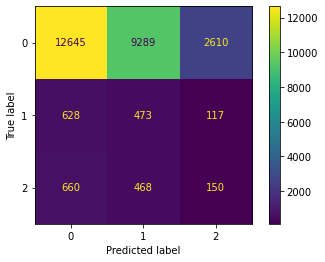

In [30]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [ ]:
cm_display = ConfusionMatrixDisplay(cm).plot()